In [1]:
%matplotlib inline
import pandas as pd
from skbio import DistanceMatrix
from os.path import join

The goal of this notebook is to analyze the differences that we are seeing between runs

Load the mapping file
---------

In [2]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')
# /home/office-microbe-files/master_map_150908.txt

In [3]:
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']

Load the distance matrix
------------------

In [4]:
weighted_dm_fp = join(home,'core_div_97/bdiv_even1000/weighted_unifrac_dm.txt')
unweighted_dm_fp = join(home,'core_div_97/bdiv_even1000/unweighted_unifrac_dm.txt')

In [5]:
weighted_dm = DistanceMatrix.read(weighted_dm_fp)
unweighted_dm = DistanceMatrix.read(unweighted_dm_fp)

In [6]:
weighted_dm.shape

(1859, 1859)

Calculate principle coordinates
---------------

In [7]:
from skbio.stats.ordination import pcoa
weighted_pcoa = pcoa(weighted_dm)
unweighted_pcoa = pcoa(unweighted_dm)

/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.5095679389910195 and the largest is 91.83819482892736.
  RuntimeWarning
/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details

Plot Weighted Principle Coordinates Analysis
----------------

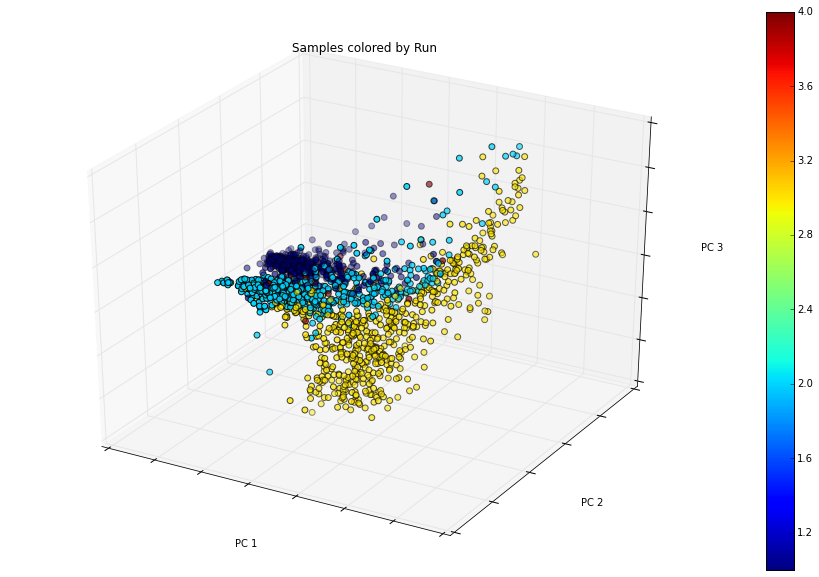

In [8]:
fig = weighted_pcoa.plot(df=sample_md,
                        column='Run',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by Run',
                        s=35).set_size_inches(16, 10)


Unweighted Principle Coordinates
---------------

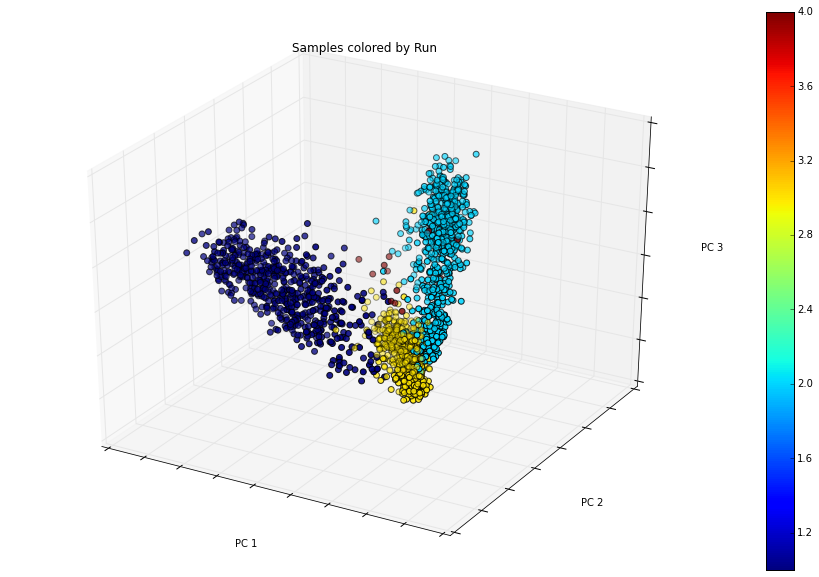

In [9]:
fig = unweighted_pcoa.plot(df=sample_md,
                        column='Run',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by Run',
                        s=35).set_size_inches(16, 10)

Obviously this doesn't look good, the next step is to figure out what is different between runs
Just for the sake of it lets see what the anosim and permanova scores are

Weighted unifrac Anosim
-----------

In [10]:
from skbio.stats.distance import anosim
anosim(weighted_dm, sample_md, column='Run', permutations=999)

method name                  ANOSIM
test statistic name               R
sample size                    1859
number of groups                  4
test statistic            0.5163179
p-value                       0.001
number of permutations          999
Name: ANOSIM results, dtype: object

Unweighted unifrac anosim
--------------

In [11]:
from skbio.stats.distance import anosim
anosim(unweighted_dm, sample_md, column='Run', permutations=999)

method name                  ANOSIM
test statistic name               R
sample size                    1859
number of groups                  4
test statistic            0.5594285
p-value                       0.001
number of permutations          999
Name: ANOSIM results, dtype: object

What is different between the runs?
-----------------

load the taxa assignments

In [12]:
taxa_map_fp = join(home, 'pick_otus_out_97/uclust_assigned_taxonomy/rep_set_tax_assignments.txt')
print(taxa_map_fp)
taxa_df = pd.read_csv(taxa_map_fp, sep='\t', names=['TaxID', 'taxonomy'], index_col=0, usecols=[0, 1], dtype=object)

/home/office-microbe-files/pick_otus_out_97/uclust_assigned_taxonomy/rep_set_tax_assignments.txt


Load the biom table

In [13]:
table_fp = join(home, 'pick_otus_out_97/otu_table_mc2_w_tax_no_pynast_failures.txt')
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0)
table.index = table.index.astype(str)

/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [14]:
from q2d2.wui import interactive_plot_taxa_summary
interactive_plot_taxa_summary(sample_md, table, taxa_df)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Obviously there are some big differences here, however this could be due to seasonal variation, We can also look at just the blank samples

In [15]:
interactive_plot_taxa_summary(sample_md, table, taxa_df)

1. identify n most abundant OTUs in each run of blanks.  
2. Remove these OTUs from the OTU table (or just the run?)
3. Rerun beta diversity and pcoa

1. Find the 5 most abundant otus in the blanks for each run
----------------------

In [16]:
run_1_ids = sample_md[(sample_md['Run'] == '1') & (sample_md['OfficeSample'] == 'no')].index
run_1_otus = table[list(set(run_1_ids) & set(table.columns))].sum(axis=1)
run_1_top_5 = run_1_otus.sort(ascending=False, inplace=False)[:5].index.tolist()


In [17]:
run_2_ids = sample_md[(sample_md['Run'] == '2') & (sample_md['OfficeSample'] == 'no')].index
run_2_otus = table[list(set(run_2_ids) & set(table.columns))].sum(axis=1)
run_2_top_5 = run_2_otus.sort(ascending=False, inplace=False)[:5].index.tolist()
run_2_top_5

['74576', '316724', '1566691', 'New.0.CleanUp.ReferenceOTU326221', '816868']

In [18]:
run_3_ids = sample_md[(sample_md['Run'] == '3') & (sample_md['OfficeSample'] == 'no')].index
run_3_otus = table[list(set(run_2_ids) & set(table.columns))].sum(axis=1)
run_3_top_5 = run_3_otus.sort(ascending=False, inplace=False)[:5].index.tolist()
run_3_top_5

['74576', '316724', '1566691', 'New.0.CleanUp.ReferenceOTU326221', '816868']

In [19]:
ids_to_drop = run_1_top_5 + run_2_top_5 + run_3_top_5

2. Remove these from the OTU table
-----------------

In [20]:
filtered_table = table.drop(ids_to_drop)
filtered_table.to_csv('otu_table_mc2_w_tax_no_pynast_failures_filtered.txt', sep='\t')

This should be run in the terminal as biom and QIIME are not py3 compatible  
biom convert -i otu_table_mc2_w_tax_no_pynast_failures_filtered.txt -o otu_table_mc2_w_tax_no_pynast_failures_filtered.biom --to-hdf5 --table-type "OTU table"  
parallel_beta_diversity.py -i otu_table_mc2_w_tax_no_pynast_failures_filtered.biom -o beta_div_filtered -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre -O 20                         


3. Rerun the above workflow to see if anything is better
-------------------------------------------------

Another thing we might want to do is see which OTUs are the most different between runs. We can't just look at what is the most different between runs because the runs are also from different seasons, however we do have some replicates so the workflow should be performed on those.

The workflow here should be:
1. Visualize the differences in replicates  
2. filter the biom table to just the counts of the replicates for the different runs (these should be *identical* samples between runs.
3. use sklearn to identify most different otus and possibly QIIME, though this will be a bit trickier... It may be good to verify the results though.
4. How well do those samples match what is different between blanks
5. If they are the same as what is in the blanks skip rerunning beta diversity
6. if they are different rerun beta diversity.

In [ ]:
htop